In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

def prepare_data(data, sequence_length, train_size=0.8):
    data = data.replace('-', np.nan)
    
    #Convertir a numeros, elimiinar nan, y 
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.fillna(data.mean())
    #escalar datos
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X, y = [], []
    for i in range(len(data_scaled) - sequence_length):
        X.append(data_scaled[i:i+sequence_length])
        y.append(data_scaled[i+sequence_length])
    X, y = torch.FloatTensor(X), torch.FloatTensor(y)
    #dividir datos
    train_size = int(len(X) * train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler


In [12]:
# Arquitectura lstm
class ProductForecastModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ProductForecastModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
def train_model(model, X_train, y_train, epochs, lr):
    #minimos cuadrados
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [18]:
def forecast(model, input_sequence, num_predictions, scaler):
    model.eval()
    current_sequence = input_sequence.clone()
    predictions = []

    for _ in range(num_predictions):
        with torch.no_grad():
            output = model(current_sequence.unsqueeze(0))
        predictions.append(output.squeeze().numpy())
        
        # Actualiza la secuencia para la siguiente prediccion
        current_sequence = torch.cat((current_sequence[1:], output), dim=0)

    # tranformada inversa para que todo funcione bien
    predictions = scaler.inverse_transform(np.array(predictions))
    return predictions


In [33]:

data = pd.read_csv('data.csv')
sequence_length = 30
X_train, X_test, y_train, y_test, scaler = prepare_data(data, sequence_length)

input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1]

model = ProductForecastModel(input_size, hidden_size, num_layers, output_size)

epochs = 500
learning_rate = 0.001

train_model(model, X_train, y_train, epochs, learning_rate)


Epoch [100/500], Loss: 0.0139
Epoch [200/500], Loss: 0.0077
Epoch [300/500], Loss: 0.0053
Epoch [400/500], Loss: 0.0047
Epoch [500/500], Loss: 0.0037


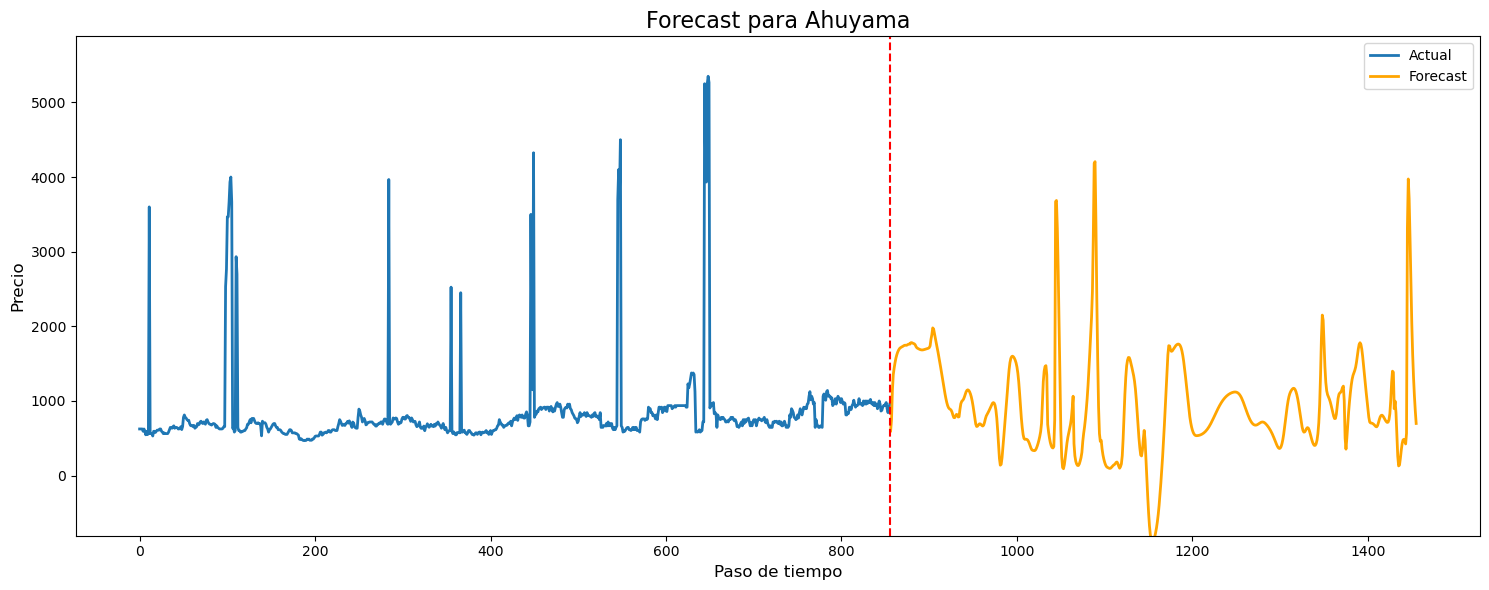

In [37]:
# forecast de los proximos 600 dias
last_sequence = X_test[-1]
forecast_horizon = 600
predictions = forecast(model, last_sequence, forecast_horizon, scaler)

#creamos la figura
plt.figure(figsize=(15, 6))
    
#todos los valores tienene que ser numericos
actual_values = pd.to_numeric(data.iloc[:, 0], errors='coerce').values
    
# ploteamos todos los valores anteriores
plt.plot(range(len(actual_values)), actual_values, label='Actual', linewidth=2)
    
 # plot de los valores de forecast
forecast_range = range(len(actual_values), len(actual_values) + forecast_horizon)
plt.plot(forecast_range, predictions[:, 0], label='Forecast', linewidth=2, color='orange')
    
plt.title(f'Forecast para {data.columns[0]}', fontsize=16)
plt.xlabel('Paso de tiempo', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.legend(fontsize=10)

#  Calculamos los valores para normalizar y tener todo dentro de los rangos
y_values = np.concatenate([actual_values, predictions[:, 0]])
y_values = y_values[~np.isnan(y_values)]  
if len(y_values) > 0:
    y_min = np.min(y_values) * 0.9
    y_max = np.max(y_values) * 1.1
    plt.ylim(y_min, y_max)

#linea vertical para definir en que momento se da el cambio
plt.axvline(x=len(actual_values) - 1, color='r', linestyle='--', label='Forecast Start')

plt.tight_layout()
plt.show()